# **ECE 132A Project: Soft Demodulation Using Neural Networks**
*Author - Minu Jung (304449985)*

Following code is an implementation and experimentation of *Machine LLRning - Learning to Softly Demodulate* by *Ori Shental* and *Jacob Hoydis (Bell Labs)*

The primary purpose of this project was to test and compare the results of demodulating signals using traditional demodulation methods using exact/approximate log-likelihood ratios, and the proposed neural net demodulator. The secondary purpose was to write the program such that the simulated communication network and the *LLRnet* can be easily customized and tested with a relatively simple interface. 

Following is the model of the simulated Transmitter:
![alt text](https://drive.google.com/uc?id=1MM7jQ56447Hp3Fxgjf0FYU8D8rCYCL3n)
Following is the model of the simulated Receiver and Decoder:
![alt text](https://drive.google.com/uc?id=1VJVxRIujo_HB_vDL_6sXrbf4_zIkVnQV)

The transmitter and receiver is save in a single object ```Transmitter_Receiver```, and the following are the commands to simulate the network. You must specify the number of bits to send, the modulation scheme, the signal to noise ratio to simulate and method of log-likeihood calculation.

All components in the transmitter and receiver were simulated, with the exception of the Parallel to Serial Converter, at cost of efficiency. For example, performance will be faster if constellation symbols were randomly generated with AWGN noise, but this approach doesn't reflect other structures in transmitter/receiver systems.

```
communication_network = Transmitter_Receiver(num_bits_send, modulation)
communication_network.send_n_receive(snr)
communication_network.decode(llr_calc = 'approx')
```
*Please note that my understanding of deep learning networks is introductory at best, which limited the scope of this project to making an easily testable, customizable system that could allow anyone to experiment with different number of layers, activation functions, loss functions, optimizers, SNRs, modulation schemes, etc and quantitatively compare bit error rates to traditional decoding system's bit error rates*


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import special as sp

def qfunc(arg):
    return 0.5-0.5*sp.erf(arg/1.414)

# Gray Coded Binary Grid to Constellation:

The modulation scheme and corresponding constellation is saved in the object ```Modulation_Map``` which is a dictionary that maps the binary stream (bit_stream) of k binary bits into exact constellation points, with the gray coded modulation schemes saved in a global 2D list. For example, if ```modulation == '16QAM'``` will use this matrix to map to constellation points using the function ```create_bin_to_coordinate_matrix```:
```
QAM_16_b = [['0000', '0100', '1100', '1000'],
           ['0001', '0101', '1101', '1001'],
           ['0011', '0111', '1111', '1011'],
           ['0010', '0110', '1110', '1010']]
```


In [0]:
QAM_64 = [[4, 12, 28, 20, 52, 60, 44, 36], 
          [5, 13, 29, 21, 53, 61, 45, 37],
          [7, 15, 31, 23, 55, 63, 47, 39],
          [6, 14, 30, 22, 54, 62, 46, 38],
          [2, 10, 26, 18, 50, 58, 42, 34],
          [3, 11, 27, 19, 51, 59, 43, 35],
          [1, 9, 25, 17, 49, 57, 41, 33],
          [0, 8, 24, 16, 48, 56, 40, 32]]

QAM_16 = [[0, 4, 12, 8],
          [1, 5, 13, 9],
          [3, 7, 15, 11],
          [2, 6, 14, 10]]

QAM_4 = [[1, 3],
         [0, 2]]

BPSK_2 = [[0, 1]]

PSK_8 = [[0, 1, 5, 4, 6, 7, 3, 2]]

QAM_64_b = [['000100', '001100', '011100', '010100', '110100', '111100', '101100', '100100'],
            ['000101', '001101', '011101', '010101', '110101', '111101', '101101', '100101'],
            ['000111', '001111', '011111', '010111', '110111', '111111', '101111', '100111'],
            ['000110', '001110', '011110', '010110', '110110', '111110', '101110', '100110'],
            ['000010', '001010', '011010', '010010', '110010', '111010', '101010', '100010'], 
            ['000011', '001011', '011011', '010011', '110011', '111011', '101011', '100011'], 
            ['000001', '001001', '011001', '010001', '110001', '111001', '101001', '100001'], 
            ['000000', '001000', '011000', '010000', '110000', '111000', '101000', '100000']]

QAM_16_b = [['0000', '0100', '1100', '1000'],
           ['0001', '0101', '1101', '1001'],
           ['0011', '0111', '1111', '1011'],
           ['0010', '0110', '1110', '1010']]

QAM_4_b = [['01', '11'],
           ['00', '10']]

BPSK_2_b = [['0', '1']]

PSK_8_b = [['000', '001', '101', '100', '110', '111', '011', '010']]

class Modulation_Map():
  def __init__(self, modulation):
    self.modulation = modulation
    if modulation == '4QAM':
      self.number_matrix, self.binary_matrix = QAM_4, QAM_4_b
    elif modulation == '16QAM':
      self.number_matrix, self.binary_matrix = QAM_16, QAM_16_b
    elif modulation == '64QAM':
      self.number_matrix, self.binary_matrix = QAM_64, QAM_64_b
    elif modulation == 'BPSK':
      self.number_matrix, self.binary_matrix = BPSK_2, BPSK_2_b
    elif modulation == '8PSK':
      self.number_matrix, self.binary_matrix = PSK_8, PSK_8_b
    self.create_num_to_bin_dictionary()
    self.create_bin_to_coordinate_dictionary()

  def create_num_to_bin_dictionary(self):
    number_matrix = self.number_matrix
    binary_matrix = self.binary_matrix
    n, d = len(number_matrix), len(number_matrix[0])
    num_to_bin = {}
    for i in range(n):
      for j in range(d):
        key = number_matrix[i][j]
        value = binary_matrix[i][j]
        num_to_bin[key] = value
    self.num_to_bin = num_to_bin
  
  def create_bin_to_coordinate_dictionary(self):
    number_matrix = self.number_matrix
    binary_matrix = self.binary_matrix
    n, d = len(number_matrix), len(number_matrix[0])
    bin_to_coordinate = {}
    for i in range(n):
      for j in range(d):
        key = binary_matrix[i][j]
        if self.modulation == '4QAM':
          value = -1 + 2*j, -1 + 2*i
        elif self.modulation == '16QAM':
          value = -3 + 2*i, -3 + 2*j
        elif self.modulation == '64QAM':
          value = -7 + 2*i, -7 + 2*j
        elif self.modulation == 'BPSK':
          value = -1 + 2*j, i 
        else: #8PSK
          value = math.sin(j*math.pi/4), math.cos(j*math.pi/4)
        bin_to_coordinate[key] = value
        self.bin_to_coordinate = bin_to_coordinate

# Transmitter and Receiver:
The transmitter consists of four main parts.

1. ```generate_bits()``` and ```serial_to_parallel()``` have rather trivial implementations. The serial-to-parallel converter divides the 1-Dimension serial bits into (k, k/n) 2-Dimensional array.

2. ```y = bit_stream_to_constellation()``` uses  ```Modulation_Map``` to map k-bits into the specific constellation coordinates based on the modulation scheme.

3.  ```snr_to_N0()``` converts the input snr into $N_0$, the noise power spectral density ratio, which twice the variance of the AWGN. The equation used to convert snr to $N_0$ was $N_0 = \frac{e_{avg}}{k\times SNR}$, where the average energy is calculated by finding the average of each symbol energy in the constellation.
4. ```r = add_noise(y, N_0/2)``` simulates AWGN with $\sigma^2 =\frac{N_0}{2}$. The final received signal is ```r```.



# Decoder, and LLR Calculation

The decoder calculates the bit least log-likelihood ratios given the received signal. There are two methods to calculate the LLR: The exact calculation and the approximate calculation. This can be specified, eg. ```decode(llr_calc = 'approx')```

# LLR Calculation

The exact LLR calculation is made by using the following equation (from Machine LLrning):
$$l_{i} \triangleq \log \left(\frac{\operatorname{Pr}\left(c_{i}=0 | \hat{\mathrm{r}}\right)}{\operatorname{Pr}\left(c_{i}=1 | \hat{\mathrm{r}}\right)}\right), \quad i=1, \ldots, k$$


$$l_{i}=\log \frac{\sum_{\mathbf{r} \in \mathcal{C}_{i}^{0}} \exp \left(-\frac{\|\hat{\mathbf{r}}-\mathbf{r}\|_{1}^{2}}{\sigma^{2}}\right)}{\sum_{\mathbf{r} \in \mathcal{C}_{i}^{1}} \exp \left(-\frac{\|\hat{\mathbf{r}}-\mathbf{r}\|_{1}^{2}}{\sigma^{2}}\right)}, \quad i=1, \ldots, k$$

Where the set of signals where the i-th bit $c_i$ is 0 or 1 is found using the Modulation_Map.

The approximate LLR calculation is made by using the following equation, which estimates the log-likeihood ratios based on the shortest distance between the symbols and the received symbols.
$$l_{i} \approx \frac{1}{\sigma^{2}}\left(\min _{\mathbf{r} \in \mathcal{C}_{i}^{1}}\|\hat{\mathbf{r}}-\mathbf{r}\|_{2}^{2}-\min _{\mathbf{r} \in \mathcal{C}_{i}^{0}}\|\hat{\mathbf{r}}-\mathbf{r}\|_{2}^{2}\right), \quad i=1, \ldots, M$$

Note that at high SNR, the exact calculation becomes numerically unstable as either the denominator or numerator reaches 0, leading to undefined behavior.

#Decoder

The decoder classifies the $i$th bit as $0$ if $l_i \geq 0$ and $1$ if $l_i < 0$

Following is the code for  ```Transmitter_Receiver```, which contains both the transmitter, receiver and decoder




In [0]:
class Transmitter_Receiver():
  def __init__(self, num_bits_send, modulation):
    self.num_bits_send = num_bits_send
    self.modulation = modulation
    self.modulation_map = Modulation_Map(modulation)
    if modulation == '4QAM':
      self.M = 4; self.k = 2; self.binary_matrix = QAM_4_b
    elif modulation == '16QAM':
      self.M = 16; self.k = 4; self.binary_matrix = QAM_16_b
    elif modulation == '64QAM':
      self.M = 64; self.k = 6; self.binary_matrix = QAM_64_b
    elif modulation == 'BPSK':
      self.M = 2; self.k = 1; self.binary_matrix = BPSK_2_b
    else: #8PSK
      self.M = 8; self.k = 3; self.binary_matrix = PSK_8_b
    
  def send_n_receive(self, snr, verbose = False):
    self.snr = snr
    N_0 = self.snr_to_N0()
    self.N_0 = N_0
    if verbose:
      print('Sending %d bits with snr = %fdB' %(self.num_bits_send, snr))
    self.generate_bits()
    self.serial_to_parallel()
    y = self.bit_stream_to_constellation()
    r = self.add_noise(y, N_0/2)
    self.r = r
    if verbose:
      plt.scatter(r[0,:], r[1, :])
      print('Finished Sending %d bits with snr = %fdB\n' %(self.num_bits_send, snr))

  def decode(self, llr_calc = 'approx', verbose=False):
    if verbose:
      print('Decoding %d bits...' %(self.num_bits_send))
    r = self.r
    n, d = np.shape(r)
    llr = np.zeros((self.k, d))
    decoded = np.zeros((self.k, d))
    for i in range(d):
      if llr_calc == 'approx':
        single_message_llr = self.r_to_llr_approx(r[:, i])
      else: #EXACT
        single_message_llr = self.r_to_llr(r[:, i])
      llr[:, i] = np.flip(single_message_llr)
      decoded[:, i] = np.flip((1-(single_message_llr/np.abs(single_message_llr)))/2)
    bit_error = np.sum(np.abs(decoded-self.bit_stream))
    bit_error_rate = bit_error/self.num_bits_send
    self.bit_error = bit_error
    self.bit_error_rate = bit_error_rate
    self.llr = llr
    self.decoded = decoded
    if verbose:
      print('Finished decoding %d bits...' %(self.num_bits_send))
      print('Number of Bit Errors: %d' %(bit_error))
      print('Bit Error Rate: %f\n' %(bit_error_rate))

  def r_to_llr(self, r):
    '''
    Returns: k array of llrs
    '''
    k = self.k
    modulation_map = self.modulation_map
    llr = np.zeros(k)
    for i in range(k):
      zero_sum, one_sum = 0, 0
      for key in modulation_map.bin_to_coordinate.keys():
        r_ = modulation_map.bin_to_coordinate[key]
        r_ = np.array([r_[0], r_[1]])
        exponent = np.linalg.norm(r-r_)
        exponent = -1*exponent/(self.N_0/2)
        total = math.exp(exponent)
        if key[k-i-1] == '0':
          zero_sum += total
        else:
          one_sum += total
      llr[i] = math.log2(zero_sum) - math.log2(one_sum)
      llr[i] = 10**-5 if llr[i] == 0 else llr[i]
    return llr    

  def r_to_llr_approx(self, r):
    '''
    Returns: k array of llrs
    '''
    k = self.k
    modulation_map = self.modulation_map
    llr = np.zeros(k)
    for i in range(k):
      zero_sum, one_sum = [], []
      for key in modulation_map.bin_to_coordinate.keys():
        r_ = modulation_map.bin_to_coordinate[key]
        r_ = np.array([r_[0], r_[1]])
        exponent = np.linalg.norm(r-r_)
        total = exponent
        if key[k-i-1] == '0':
          zero_sum.append(total)
        else:
          one_sum.append(total)
      llr[i] = (min(one_sum) - min(zero_sum)) #/(self.N_0/2)
      llr[i] = 10**-5 if llr[i] == 0 else llr[i]
    return llr 
  
  def snr_to_N0(self):
    '''
    Returns: float N0
    '''
    k, M, snr = self.k, self.M, 10**(self.snr/10)
    sum = 0
    for value in self.modulation_map.bin_to_coordinate.values():
      sum += value[0]**2+value[1]**2
    e_avg = sum/M
    return e_avg/(k*snr)

  def generate_bits(self):
    '''
    Sets bit_stream to: num_bits_send, 1 array of bits
    '''
    bit_stream = np.around(np.random.rand(self.num_bits_send,1))
    self.bit_stream = bit_stream

  def serial_to_parallel(self):
    '''
    Sets bit_stream to: k, n/k array of bits
    '''
    k = self.k
    c = self.bit_stream
    n, d = np.shape(c)
    
    if n%k == 0:
      copy = np.transpose(c.reshape((int(n/k), k)))
      self.bit_stream = copy
    else:
      copy = np.append(c, np.zeros((k-n%k,1)))
      n_, = np.shape(copy)
      self.bit_stream = np.transpose(copy.reshape((int(n_/k), k)))  
  
  def bit_stream_to_constellation(self):
    '''
    Returns: 2,d array of 2-D coordinate points
    '''
    modulation = self.modulation
    modulation_map = self.modulation_map
    bit_stream = self.bit_stream
    n,d = np.shape(bit_stream)
    constellation = np.zeros((2,d))

    for j in range(d):
      stream = bit_stream[:, j]
      key = ''
      for bit in stream:
        key += str(int(bit))
      x1, y1 = modulation_map.bin_to_coordinate[key]
      constellation[0, j], constellation[1,j] = x1, y1
    return constellation

  def add_noise(self, y, var):
    n, d = np.shape(y)
    return y + math.sqrt(var)*np.random.randn(n, d)

#Example Constellation Plots
Following are the constellation plots for all modulations with 20dB SNR

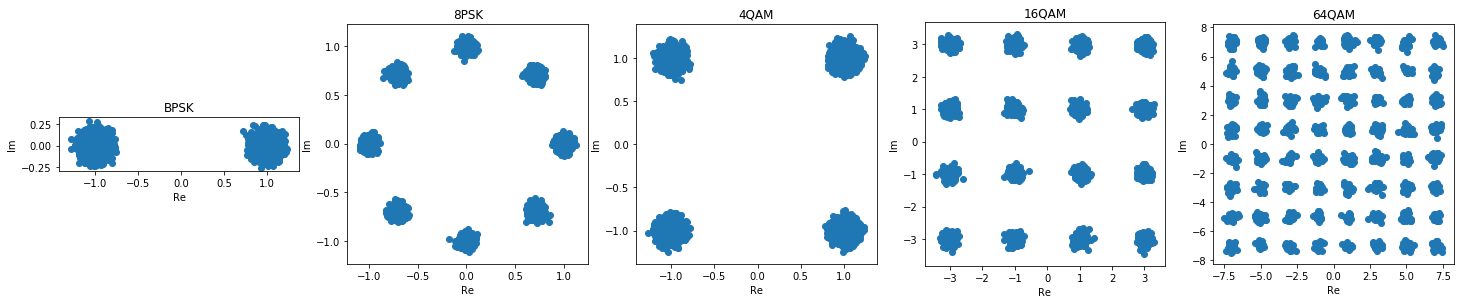

In [0]:
modulation_list = ['BPSK', '8PSK', '4QAM', '16QAM', '64QAM']
snr = 20
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (25, 5))
axes = [ax1, ax2, ax3, ax4, ax5]
for modulation, ax in zip(modulation_list, axes):
  comm_sys = Transmitter_Receiver(10000, modulation)
  comm_sys.send_n_receive(snr) 
  ax.scatter(comm_sys.r[0,:], comm_sys.r[1,:])
  ax.set_title(modulation)
  ax.set_xlabel('Re'); ax.set_ylabel('Im')
  ax.set_aspect('equal')


#Theoretical Bit Error Rate Calculation and Comparison

#MAP detection Probability of Error:

When using the optimal detector, i.e. MAP detector, we seek to detect the signal that is

<script src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js?config=TeX-AMS_SVG-full" type="text/javascript"></script>

$$\underset{m}{\operatorname{arg max}}{P}(s_m|r) = \underset{m}{\operatorname{arg max}}\frac{P(r|s_m)P(s_m)}{P(r)}$$

In equiprobable signals (as is the case here, MAP detector reduces to ML detector)
$$\underset{m}{\operatorname{arg max}}{P}(s_m|r) = \underset{m}{\operatorname{arg max}}P(r|s_m)$$

Assuming that the received signal $P(r|s_m)$ is a multivariate normal distribution with diagonal covariance matrix (independent)
$$f(r|s_m)=(\pi N_0)^{-\frac{d}{2}}\prod_{i=0}^{d-1}e^{-\frac{2}{N_0}(r_i-s_{mi})^2}$$
$$r, s_m \in \mathbb{C}^d$$
Taking the natural log of the likelihood and disregarding values that do not effect argmax, we can arrive at the optimal detector value

$$\underset{m}{\operatorname{arg max}}{P}(s_m|r) = \underset{m}{\operatorname{arg min}} ||r-s_m||^2$$

This imposes a decision region for each $s_m$ such that the closest constellation point within that region is $s_m$. In the case of binary signals, the threshold is 0, which makes the probability of error easy to calculate:

$$P(e) = P(e|s_1)P(s_1)+P(e|s_0)P(s_0)$$
$$P(e) = \int_{-\infty}^{0}f(r|s_1)dr\cdot P(s_1) + \int_{0}^{\infty}f(r|s_2)dr\cdot P(s_2)$$
$$f(r|s_m)= \frac{1}{\sqrt{\pi N_0}}e^{-\frac{(r-s_m)^2}{N_0}}$$

Therefore the probability of error can be reduced to the Q function,
$$P(e) = 0.5(1-Q((\frac{\sqrt{\epsilon_b}}{\sqrt{\frac{N_0}{2}}}))) + 0.5Q(-(\frac{\sqrt{\epsilon_b}}{\sqrt{\frac{N_0}{2}}})))$$
For equiprobable signal. Note that $1-Q(-x) = Q(x)$
$$\therefore P(e) = 0.5\times 2Q(\sqrt{\frac{2\epsilon_b}{N_0}}) = Q(\sqrt{\frac{2\epsilon_b}{N_0}})$$
This can be reduced to $P(e) = Q\left(\frac{d_{min}}{\sqrt{2N_0}}\right)$, as $d_{min} = 2\sqrt{e_b}$

However, calculating probability of error quickly becomes complicated for other modulation schemes that do not have simple regions of detection.

Therefore, instead of the exact probability, we aim to find a bound on the probability of error, using Union Bound.

With equiprobable signals, the probability of error can be reduced to:
$$P(e) = P(e|s_m) = \sum_{i=1}^{M}P(s_i \text{ detected} | s_m \text{ sent}) \text{ for } i \neq m$$
From the section above, $P(s_i \text{ detected} | s_m \text{ sent})$ means that $||r-s_i||^2 < ||r-s_m||^2 $, meaning it can be modeled ass a binary equiprobable signaling system, for which the probability of error was found above:
$$Q\left(\frac{d_{m:i}}{\sqrt{2N_0}}\right)$$
$$\therefore P(e) = P(e|s_m) = \sum_{i=1}^{M}Q\left(\frac{d_{m:i}}{\sqrt{2N_0}}\right) \text{, }i\neq m $$

Since the Q function is monotonically decreasing, $Q\left(\frac{d_{m:i}}{\sqrt{2N_0}}\right) \leq Q\left(\frac{d_{min}}{\sqrt{2N_0}}\right) $
$$\therefore \sum_{i=1}^{M}Q\left(\frac{d_{m:i}}{\sqrt{2N_0}}\right) \leq (M-1)Q\left(\frac{d_{min}}{\sqrt{2N_0}}\right) $$

Therefore, the approximation for probability of symbol error is: 

$$P(e) \approx (M-1)Q\left(\frac{d_{min}}{\sqrt{2N_0}}\right) $$

The proof for bit error rates for all modulation schemes is not shown here, but the following table was used:
$$\begin{array}{lll}
\text { Modulation } & P_{s}\left(\gamma_{s}\right) & P_{b}\left(\gamma_{b}\right) \\
\hline \text { BPSK } & & P_{b}=Q(\sqrt{2\gamma_b}) \\
\text { QPSK } & P_{s} \approx 2 Q(\sqrt{\gamma_{s}}) & P_{b} \approx Q(\sqrt{2 \gamma_{b}}) \\
\text { 8PSK } & P_{s} \approx 2 Q\left(\sqrt{2 \gamma_{s}} \sin \left(\frac{\pi}{8}\right)\right) & P_{b} \approx \frac{2}{\log_{2} 8} Q(\sqrt{2 \gamma_{b} \log _{2} M} \sin(\frac{\pi}{8}) \\
\text { M-QAM } & P_{s} \approx 4 Q(\sqrt{\frac{3\gamma_s}{M-1}}) & P_{b} \approx \frac{4}{\log _{2} M} Q(\sqrt{\frac{3\gamma_b log_{2}M}{M-1}})
\end{array}$$

where $\gamma_b = \frac{\epsilon_b}{N_0}$, the SNR per bit.

In [0]:
def theoretical_bit_error_rate(modulation, SNR_dB):
  snr = 10**(SNR_dB/10)
  if modulation == 'BPSK':
    bit_error = qfunc((2*snr)**0.5)
  elif modulation == '8PSK':
    M = 8
    bit_error = 2/((math.log2(M)))*qfunc(math.sin(math.pi/M)*(2*snr*math.log2(M))**0.5)
  elif modulation == '4QAM' or modulation == '16QAM' or modulation == '64QAM':
    M = 4 if modulation == '4QAM' else 16 if modulation == '16QAM' else 64
    bit_error = 4/((math.log2(M)))*qfunc((3*snr*math.log2(M)/(M-1))**0.5)
  else:
    print('Must choose valid modulation')
    return 0
  return bit_error

Following graphs checks whether the theoretical BER coincides with the optimal detector BER

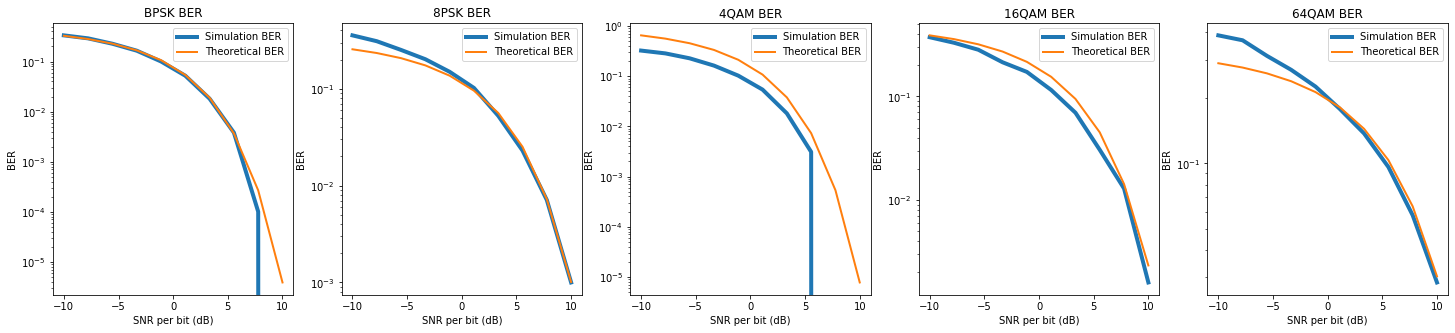

In [0]:
snr_list = np.linspace(-10, 10 ,10)
modulation_list = ['BPSK', '8PSK', '4QAM', '16QAM', '64QAM']
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (25, 5))
axes = [ax1, ax2, ax3, ax4, ax5]
for modulation, ax in zip(modulation_list, axes):
  conventional_error = []
  th_error = []
  for snr in snr_list:
    comm_sys = Transmitter_Receiver(10000, modulation)
    comm_sys.send_n_receive(snr)
    comm_sys.decode()
    conventional_error.append(comm_sys.bit_error_rate)
    th_error.append((theoretical_bit_error_rate(modulation, snr)))
  ax.semilogy(snr_list, conventional_error, linewidth = 4, label = 'Simulation BER')
  ax.semilogy(snr_list, th_error, linewidth = 2, label = 'Theoretical BER')
  ax.set_xlabel('SNR per bit (dB)'); ax.set_ylabel('BER')
  ax.legend()
  ax.set_title(modulation + ' BER')


# LLR_net

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras import optimizers
from keras import initializers

LLR_net is a customizable sequential feed forward neural network decoder, and parameters for the model can be defined in the declaration. For example:
```
modulation, training_size, test_size = '4QAM', 100, 1000
train_snr, test_snr = 10, 15
epoch_size, activation, optimizer, loss = 100, 'relu', 'adam', 'mse'
neuron_size, layer_num = 8, 2
llr_net = LLR_net(modulation, training_size, test_size, train_snr = train_snr, test_snr = test_snr,
                  epoch_size = epoch_size, activation = activation, optimizer = optimizer, 
                  loss = loss, neuron_size = neuron_size, layer_num = layer_num)
```
The above declaration sets up a 4QAM decoder trained on 100 samples at SNR = 10dB with 100 epochs, tested on 1000 samples at SNR = 15dB. There will be 2 layers with 8 neurons, with activation function 'relu', optimizer 'adam' with loss fuction 'mse'. 

**Note that in the original paper, the primary goal was to decode signals with lower complexity, which was only possible for ONE hidden layer with less than 8 neurons. Adding additional layers adds to complexity, and will be slower than traditional minimum distance calculations**


In [0]:
class LLR_net():
  def __init__(self, modulation, training_size, test_size, train_snr=10, test_snr=10, epoch_size=100,
               activation = 'tanh', optimizer = 'adam', loss = 'mse', neuron_size = 16, layer_num = 1):
    self.loss, self.optimizer = loss, optimizer
    self.modulation = modulation
    self.train_snr, self.test_snr = train_snr, test_snr
    self.training_size, self.test_size = training_size, test_size
    '''
    Model Definition: Sequential
    Model Paramters: The parameters can be specified in the declaration. Optimization of Parameters
                      are given in next sections
    Note:
    Last Layer is defined in the training system to account for different 'k' values
    '''
    model = Sequential()
    model.add(Dense(neuron_size, input_dim=2, activation = activation))
    for i in range(layer_num):
        model.add(Dropout(0.2))
        model.add(Dense(neuron_size, activation = activation))
    self.model = model
    self.epoch_size = int(epoch_size)
  
  def train(self, verbose = 0):
    '''
    Generates Training Data by
    1. Defining a Transmitter/Receiver for the given number of training bits, modulation and snr
    2. Maps the bits to constellation with AWGN -> This is the Training Data, X
    3. Decodes using tradition decoding -> This is the Training Data, y
    4. Trains the Neural Network using the Training Data
    '''
    self.training_system = Transmitter_Receiver(self.training_size, self.modulation)
    self.training_system.send_n_receive(self.train_snr)
    self.training_system.decode()
    self.model.add(Dense(self.training_system.k, activation='linear'))

    X = np.transpose(self.training_system.r)
    y = np.transpose(self.training_system.llr)
    self.model.compile(loss = self.loss, optimizer = self.optimizer , metrics=['mse'])
    self.model.fit(X, y, epochs=self.epoch_size, batch_size=50, verbose = verbose) 
  
  def test(self, verbose = False):
    '''
    Tests the model by:
    1. Defining a Transmitter/Receiver for the given number of testing bits, modulation and snr
    2. Maps the bits to constellation with AWGN -> This is the Training Data, X
    3. Decodes using tradition decoding -> This is the 'true' value, y
    '''
    self.test_system = Transmitter_Receiver(self.test_size, self.modulation)
    self.test_system.send_n_receive(self.test_snr)
    self.test_system.decode()

    X = np.transpose(self.test_system.r)
    self.predictions = self.model.predict(X)
    self.decode = np.transpose(0.5*(-1*self.predictions/np.abs(self.predictions)+1))
    self.num_error = np.sum(np.abs(self.test_system.bit_stream-self.decode))
    self.b_error = self.num_error/self.test_system.num_bits_send
    self.conventional_error = self.test_system.bit_error/self.test_system.num_bits_send
    self.accuracy = 1- np.average(np.abs(self.predictions.T - self.test_system.llr)/ np.abs(self.test_system.llr)) 
    if verbose:
      print('Conventional Decoder bit error rate is %f' %(self.conventional_error))
      print('LLR Net bit error rate is %f' %(self.b_error))

# Verification of LLRnet's accuracy with matching training/testing SNR
Following are plots ranging from -10dB to 20dB SNR to compare the bit-error rates of the conventional decoder versus the llr-net decoder. Note that the training and testing are done at the same SNR. 

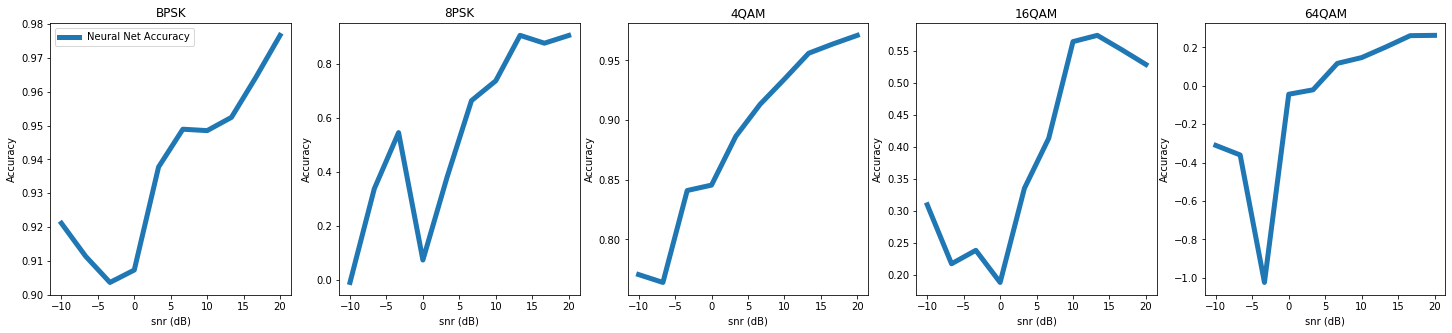

In [9]:
snr_list = np.linspace(-10, 20, 10)
modulation_list = ['BPSK', '8PSK', '4QAM', '16QAM', '64QAM']
llr_net_accuracy = [[] for i in modulation_list]

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (25, 5))
axes = [ax1, ax2, ax3, ax4, ax5]

for n, modulation in enumerate(modulation_list):
  for snr in snr_list:
    a = LLR_net(modulation, 1000, 10000, train_snr = snr, test_snr = snr, activation = 'tanh')
    a.train()
    a.test()
    llr_net_accuracy[n].append(a.accuracy)
  axes[n].plot(snr_list, llr_net_accuracy[n], linewidth = 5, label = 'Neural Net Accuracy')
  axes[n].set_title(modulation)
  axes[n].set(xlabel = 'snr (dB)', ylabel = 'Accuracy')
ax1.legend()

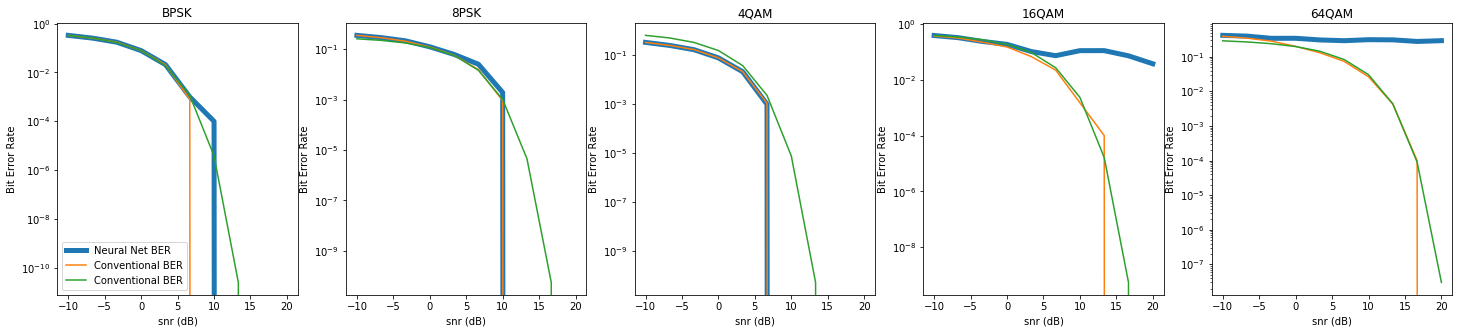

In [19]:
snr_list = np.linspace(-10, 20, 10)
modulation_list = ['BPSK', '8PSK', '4QAM', '16QAM', '64QAM']
llr_conventional = [[] for i in modulation_list]
conventional_error = [[] for i in modulation_list]
th_error = [[] for i in modulation_list]

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (25, 5))
axes = [ax1, ax2, ax3, ax4, ax5]

for n, modulation in enumerate(modulation_list):
  for snr in snr_list:
    a = LLR_net(modulation, 1000, 10000, train_snr = snr, test_snr = snr, activation = 'tanh')
    a.train()
    a.test()
    llr_conventional[n].append(a.b_error)
    conventional_error[n].append(a.conventional_error)
    th_error[n].append(theoretical_bit_error_rate(modulation, snr))
  axes[n].semilogy(snr_list, llr_conventional[n], linewidth = 5, label = 'Neural Net BER')
  axes[n].semilogy(snr_list, conventional_error[n], label = 'Conventional BER')
  axes[n].semilogy(snr_list, th_error[n], label = 'Conventional BER')
  axes[n].set_title(modulation)
  axes[n].set(xlabel = 'snr (dB)', ylabel = 'Bit Error Rate')
ax1.legend()

# Verification of LLRnet's accuracy with mixed training/testing SNR
Following are plots ranging from mixed -10dB to 20dB SNR to compare the bit-error rates of the conventional decoder versus the llr-net decoder. Note that the training and testing are done at the same SNR. The legend is identical to above

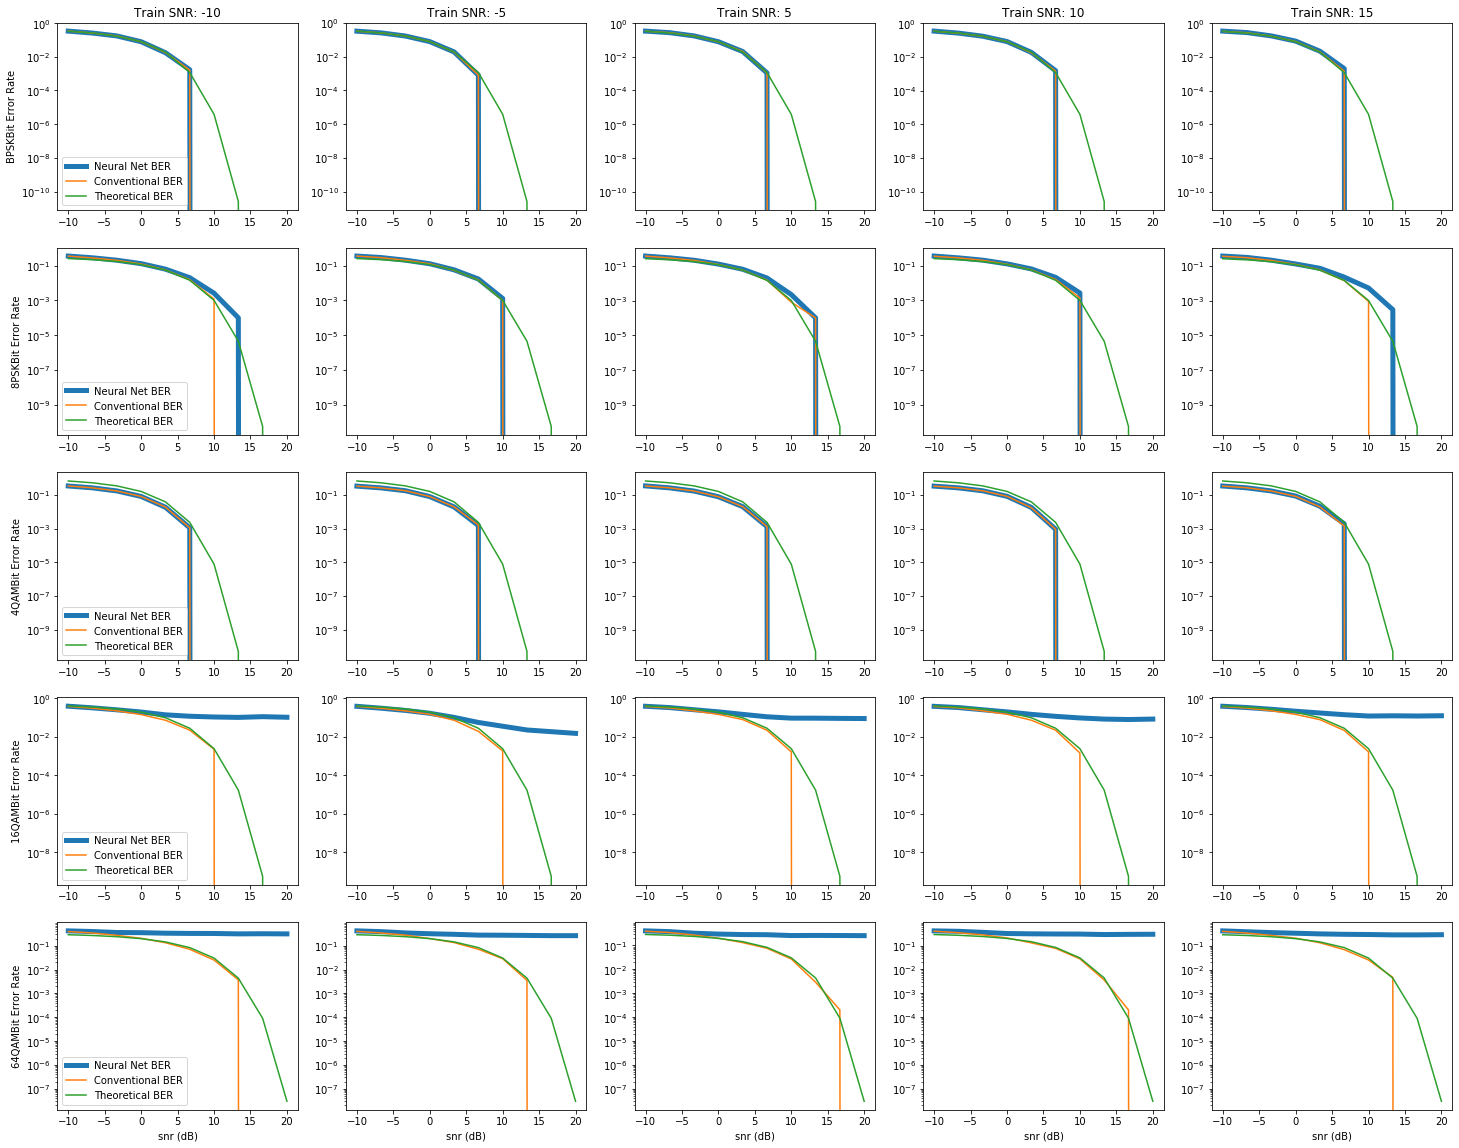

In [0]:
test_snr_list = np.linspace(-10, 20, 10)
train_snr_list = np.array([-10, -5, 5, 10, 15])

modulation_list = ['BPSK', '8PSK', '4QAM', '16QAM', '64QAM']

fig, ((ax1, ax2, ax3, ax4, ax5),
      (ax6, ax7, ax8, ax9, ax10),
      (ax11, ax12, ax13, ax14, ax15),
      (ax16, ax17, ax18, ax19, ax20),
      (ax21, ax22, ax23, ax24, ax25)) = plt.subplots(5, 5, figsize = (25, 20))

axes = [[ax1, ax2, ax3, ax4, ax5],
        [ax6, ax7, ax8, ax9, ax10],
        [ax11, ax12, ax13, ax14, ax15],
        [ax16, ax17, ax18, ax19, ax20],
        [ax21, ax22, ax23, ax24, ax25]]

for i, modulation in enumerate(modulation_list):
  for j, train_snr in enumerate(train_snr_list):
    llr_net_error = []; conventional_error = []; th_error = []
    for n, test_snr in enumerate(test_snr_list):
        if n == 0:
          a = LLR_net(modulation, 1000, 10000, train_snr = train_snr, test_snr = test_snr, activation = 'tanh')
          a.train()
        a.test_snr = test_snr
        a.test()
        llr_net_error.append(a.b_error)
        conventional_error.append(a.conventional_error)
        th_error.append(theoretical_bit_error_rate(modulation, test_snr))

    axes[i][j].semilogy(test_snr_list, llr_net_error, linewidth = 5, label = 'Neural Net BER')
    axes[i][j].semilogy(test_snr_list, conventional_error, label = 'Conventional BER')
    axes[i][j].semilogy(test_snr_list, th_error, label = 'Theoretical BER')
    if i == 0:
      axes[i][j].set_title('Train SNR: ' + str(train_snr))
    if j == 0:
      axes[i][j].set(ylabel = modulation + 'Bit Error Rate')
      axes[i][j].legend()
    if i == 4:
      axes[i][j].set(xlabel = 'snr (dB)')



#Model Correction with data from mixed training/testing SNR

Training and testing the model and different SNRs showed that for 16QAM and 64QAM, the best results were obtained when the model was trained at high SNR. Training SNR doesn't make an difference for the other modulation schemes (BPSK, 8PSK, 4QAM).

Given this information, we can make modifications to the optimal model by training the model at high SNR for all test cases.

In addition, we can infer from the difference in 16QAM and 64QAM that first, the model is able to predict to some degree of success (although higher in error than the conventional decoding), and secondly, the model does worse in higher dimensional feature space. Therefore, increasing the number of epochs may help the model perform better.



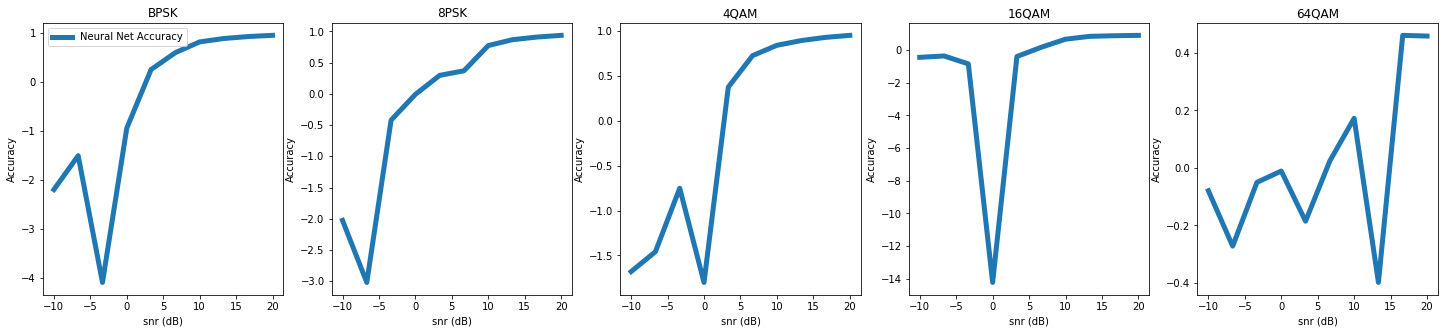

In [10]:
train_snr = 40
epoch_size = 300

snr_list = np.linspace(-10, 20, 10)
modulation_list = ['BPSK', '8PSK', '4QAM', '16QAM', '64QAM']
llr_net_accuracy = [[] for i in modulation_list]

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (25, 5))
axes = [ax1, ax2, ax3, ax4, ax5]

for n, modulation in enumerate(modulation_list):
  a = LLR_net(modulation, 1000, 10000, train_snr = train_snr, test_snr = -10, activation = 'tanh',
              epoch_size = epoch_size)
  a.train()
  for snr in snr_list:
    a.test_snr = snr
    a.test()
    llr_net_accuracy[n].append(a.accuracy)
  axes[n].plot(snr_list, llr_net_accuracy[n], linewidth = 5, label = 'Neural Net Accuracy')
  axes[n].set_title(modulation)
  axes[n].set(xlabel = 'snr (dB)', ylabel = 'Accuracy')
ax1.legend()

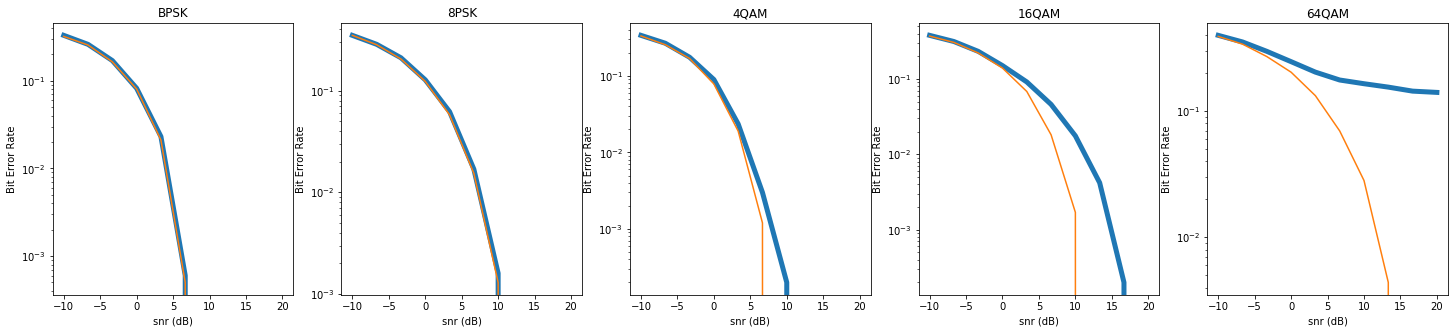

In [0]:
train_snr = 40
epoch_size = 300

snr_list = np.linspace(-10, 20, 10)
modulation_list = ['BPSK', '8PSK', '4QAM', '16QAM', '64QAM']
llr_net_error = [[] for i in modulation_list]
conventional_error = [[] for i in modulation_list]

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (25, 5))
axes = [ax1, ax2, ax3, ax4, ax5]

for n, modulation in enumerate(modulation_list):
  a = LLR_net(modulation, 1000, 10000, train_snr = train_snr, test_snr = snr, activation = 'tanh', epoch_size= 300)
  a.train()
  for snr in snr_list:
    a.test_snr = snr
    a.test()
    llr_net_error[n].append(a.b_error)
    conventional_error[n].append(a.conventional_error)
  axes[n].semilogy(snr_list, llr_net_error[n], linewidth = 5)
  axes[n].semilogy(snr_list, conventional_error[n])
  axes[n].set_title(modulation)
  axes[n].set(xlabel = 'snr (dB)', ylabel = 'Bit Error Rate')


#Effect of additional layers in Neural Net for 64QAM

We have seen that LLR_net is highly effective for decoding signals in BPSK, 8PSK and 4QAM but don't work as well in 16-QAM and 64-QAM. However, training at high SNR with increased epoch size helped LLR_net be reliable at 16-QAM, but not 64-QAM.

This section seeks to verify whether additional hidden layers would help decrease the bit error rate in 64QAM.

Testing and simulating 64QAM LLR_net decoder for layers 1-4 showed that there was no relationship between the number of layers and bit detection performance.

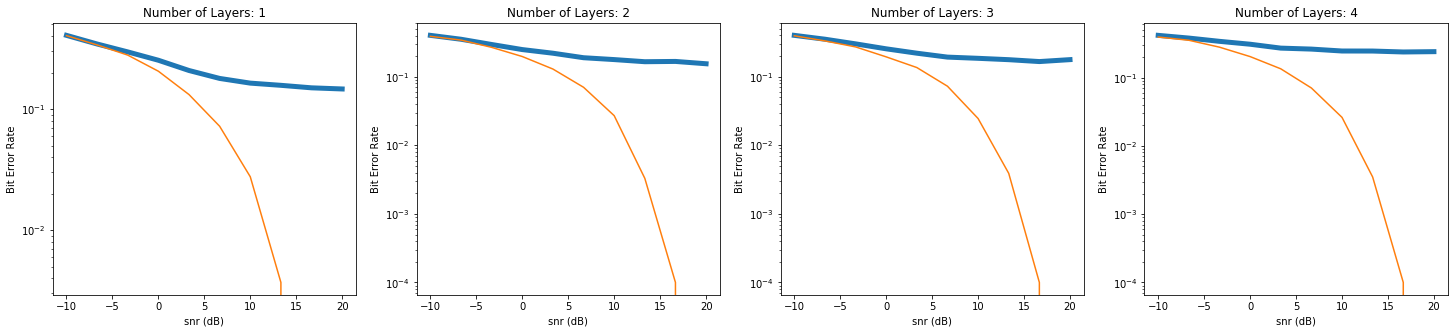

In [0]:
snr_list = np.linspace(-10, 20, 10)
layer_num_list = [1, 2, 3, 4]
modulation = '64QAM'
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (25, 5))
axes = [ax1, ax2, ax3, ax4]
for n, layer_num in enumerate(layer_num_list):
  a = LLR_net(modulation, 1000, 10000, train_snr = 50, test_snr = -10, activation = 'tanh',
            epoch_size=300, layer_num=layer_num)
  a.train()
  llr_net_error = []; conv_error = []
  for snr in snr_list:
    a.test_snr = snr
    a.test()
    llr_net_error.append(a.b_error)
    conv_error.append(a.conventional_error)
  axes[n].semilogy(snr_list, llr_net_error, linewidth = 5)
  axes[n].semilogy(snr_list, conv_error)
  axes[n].set_title('Number of Layers: ' + str(layer_num))
  axes[n].set(xlabel = 'snr (dB)', ylabel = 'Bit Error Rate')


#Conclusion
The two goals behind the project was:
1. Simulate with as much fidelity as possible transmitter, receiver and decoder. 
2. Implement the most optimized neural network decoder, and in the process develop an easily testable, customizable model for others who may be interested in this area.

The first objective was successful in the scope of the project. However, additional components, such as analog to digital, digital to analog, codewords, would've more closely reflected a real communications system. However, given the limited scope, I believe the communication system reflects well on the theoretical system taught in the course.

The second objective had limited success, and did not meet the criteria of which the authors of the original paper achieved. The bit error rate for 64-QAM was too high to be viable for reliable decoding. However, for BPSK, 8PSK, 4QAM and 16QAM (with additional epochs), it was found that training LLR_net at high SNR for 300 epochs allowed the LLR_net decoder to closely mimic the bit error rate of the traditional decoding system.